# NLP project: SMS Text Spam Classification

In [122]:
import nltk
import gensim
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import os
import time

os.chdir('/Users/kevnguyen/Documents/NLP/Project')

## Read in semi-structured text data

In [2]:
df = pd.read_table('smsspamcollection/SMSSpamCollection', header=None)

df.head() # print data frame

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#rename columns
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Cleaning

In [4]:
pd.set_option('display.max_colwidth', 100) #increase number of characters printed

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


### Tokenize, Stemming/Lemming, remove stopwords, remove special characters, set to lowercase

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(x, kind = 'lemmatize', ngram = False):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w]+')

    x = x.lower() #lowercase
    x = tokenizer.tokenize(x) # remove special characters/punctuation
    x = [word for word in x if word not in stopwords] # remove stopwords
    
    #stemmer or lemmatizer
    if (kind.lower().strip() == 'stem'): 
        ps = nltk.PorterStemmer()
        x = " ".join([ps.stem(word) for word in x]) if ngram else [ps.stem(word) for word in x] #stem
    else:
        wn = nltk.WordNetLemmatizer()
        x =  " ".join([wn.lemmatize(word) for word in x]) if ngram else [wn.lemmatize(word) for word in x] # lemmatize 
    
        
    return x
    

df['cleaned'] = df['text'].apply(lambda x: clean_text(x, ngram = False))

df.head()

,label,text,cleaned
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]"


## Feature Engineering

### Message Length

In [ ]:
df.head()

,label,text,cleaned
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]"


In [ ]:
df['length'] = df['text'].apply(lambda x: len(x) - x.count(' '))
df.head()

,label,text,cleaned,length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]",92
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",24
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",128
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",39
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]",49


### Pct of message that is punctuation

In [ ]:
def count_punct(text):
    count = sum(1 for char in text if char in string.punctuation)
    return round(count/(len(text) - text.count(' ')), 3) * 100
    
df['pct_punct'] = df['text'].apply(count_punct)
df.head()

,label,text,cleaned,length,pct_punct
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]",92,9.8
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",128,4.7
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",39,15.4
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]",49,4.1


In [ ]:
def count_caps(text):
    count = sum(1 for char in text if char.isupper())
    return round(count/(len(text) - text.count(' ')), 3) * 100
df['pct_cap'] = df['text'].apply(count_caps)
df.head()

,label,text,cleaned,length,pct_punct,pct_cap
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]",92,9.8,3.3
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",24,25.0,8.3
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",128,4.7,7.8
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",39,15.4,5.1
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]",49,4.1,4.1


## Exploratory Data Analysis

### Data shape

In [10]:
print('Input data has {:,} rows and {:,} columns'.format(df.shape[0], df.shape[1]))
# df.shape

Input data has 5,572 rows and 6 columns


### How many texts are spam/ham?

In [11]:
print('Out of {:,} rows: \n\t{:,} are spam \n\t{:,} are ham'.format(df.shape[0],
                                                                df['label'].value_counts()['spam'], 
                                                                df['label'].value_counts()['ham']))
# df['label'].value_counts()

Out of 5,572 rows: 
	747 are spam 
	4,825 are ham


### How much of the data are missing?

In [12]:
print('Number of null in labels:', df['label'].isnull().sum())
print('Number of null in text:', df['text'].isnull().sum())
# df.isnull().sum()

Number of null in labels: 0
Number of null in text: 0


### Data Vizualization

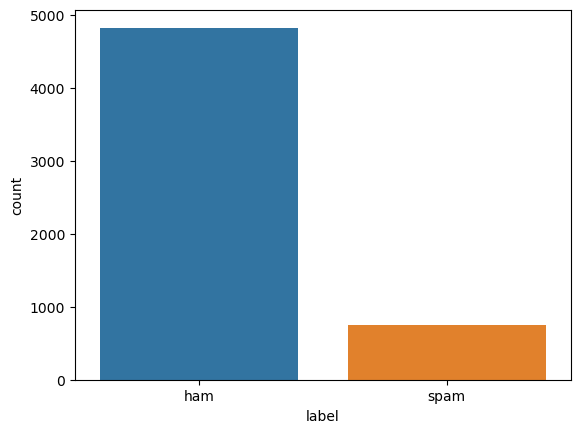

In [13]:
sns.countplot(df, x = 'label')
plt.show()

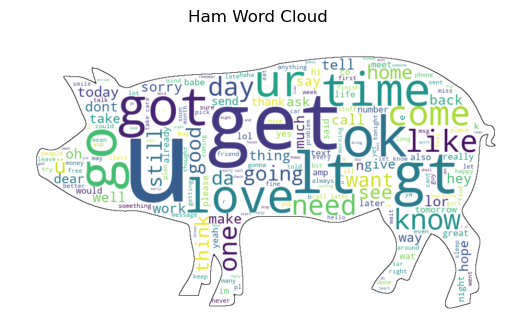

In [14]:
pig = np.array(Image.open('pig-silhouette-images-7.png'))
df['cleaned_ngram'] = df['text'].apply(lambda x: clean_text(x, ngram=True))


text = " ".join(text for text in df[df['label']=='ham'].cleaned_ngram)
wordcloud = WordCloud(stopwords = stopwords, background_color="white", mask = pig, contour_width = 1).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis([100, 1050, 850, 300])
plt.title('Ham Word Cloud')
plt.axis('off')
plt.show()

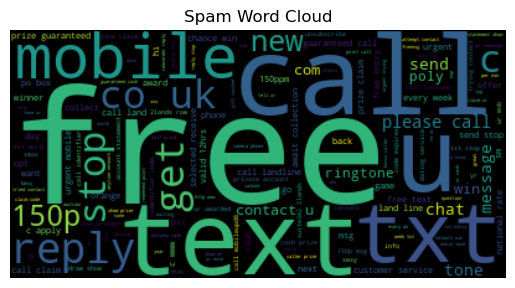

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

text = " ".join(text for text in df[df['label']=='spam'].cleaned_ngram)

wordcloud = WordCloud(stopwords = stopwords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Spam Word Cloud')
plt.show()

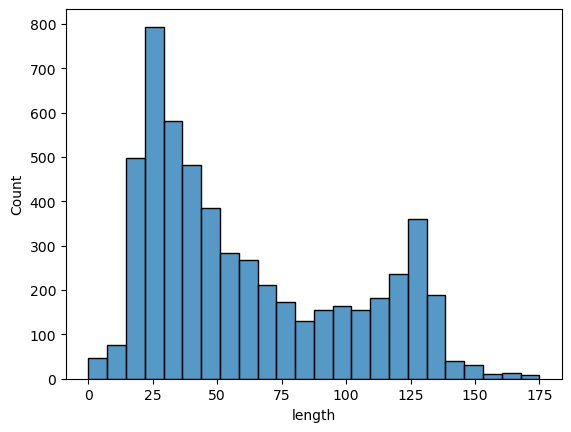

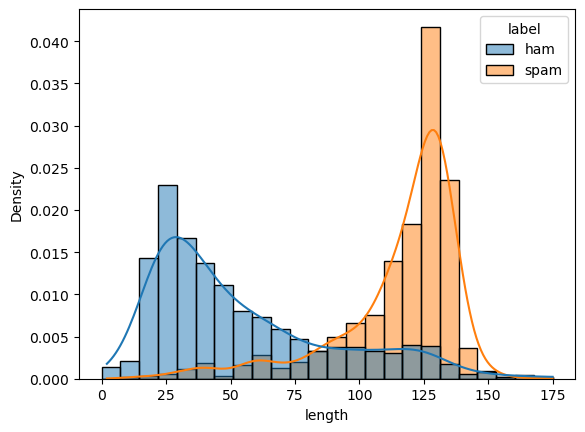

In [16]:
sns.histplot(df, x = 'length', binrange = (0,175))
plt.show()

sns.histplot(df, x = 'length', hue = 'label', binrange = (0, 175), stat = 'density',common_norm=False, kde = True, kde_kws={'clip': (0, 175)})
plt.show()

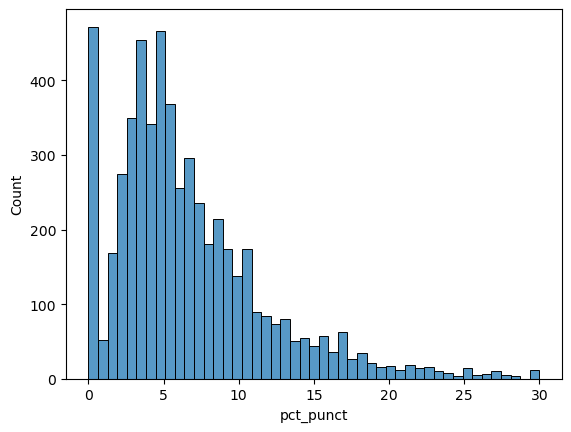

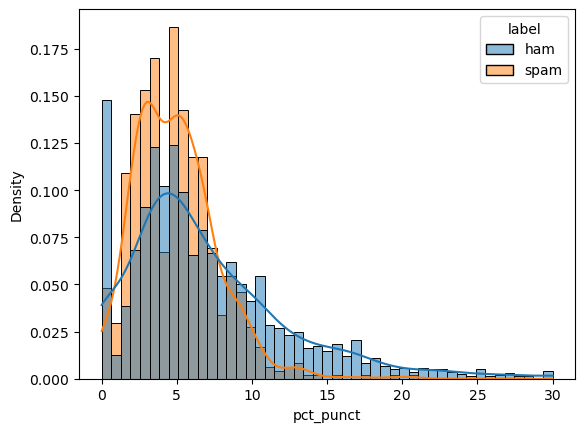

In [17]:
sns.histplot(df, x = 'pct_punct', binrange = (0,30))
plt.show()

sns.histplot(df, x = 'pct_punct', hue = 'label', binrange = (0,30), stat = 'density',common_norm=False, kde = True,  kde_kws={'clip': (0, 30)})
plt.show()

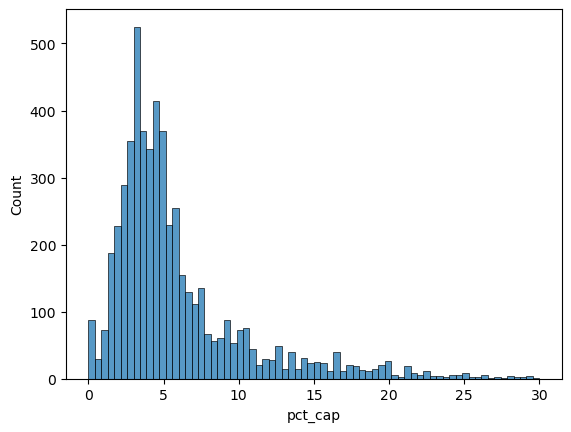

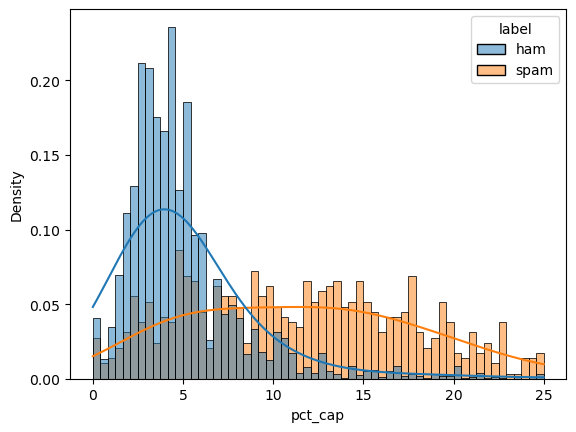

In [18]:
sns.histplot(df, x = 'pct_cap', binrange = (0,30))
plt.show()

sns.histplot(df, x = 'pct_cap', hue = 'label', binrange = (0,25), kde = True, stat = 'density',common_norm=False, kde_kws={'clip': (0, 25)})
plt.show()

#### Log-Transformations

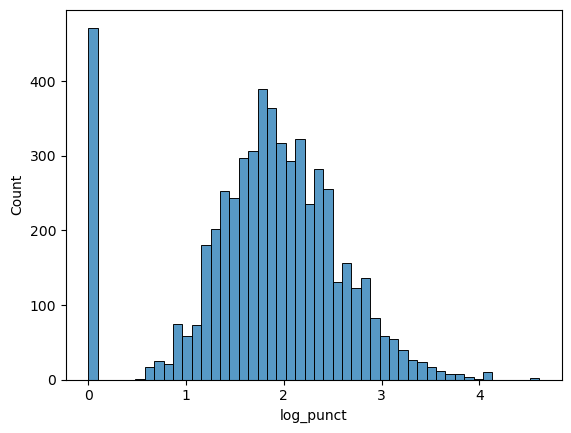

In [19]:
df['log_punct'] = np.log(df['pct_punct']+1)
sns.histplot(df, x = 'log_punct')
plt.show()

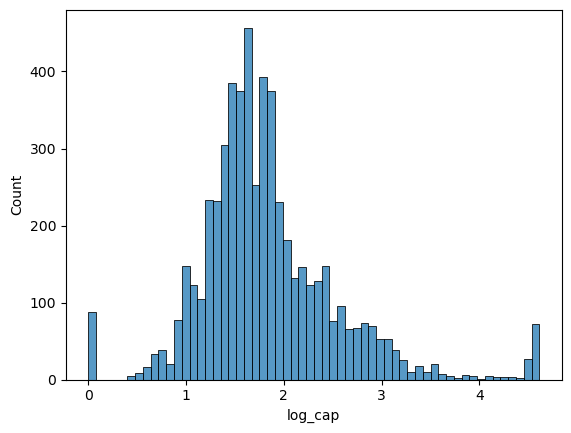

In [20]:
df['log_cap'] = np.log(df['pct_cap']+1)
sns.histplot(df, x = 'log_cap')
plt.show()

## Vectorize

In [165]:
X_train_df, X_test_df, y_train, y_test = train_test_split(df[['text', 'length','log_punct', 'log_cap']], df['label'], random_state=1)
X_train_df.head()

,text,length,log_punct,log_cap
710,4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths+? Call ...,135,1.686399,2.208274
3740,Did you stitch his trouser,22,0.000000,1.704748
2711,Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provi...,103,1.774952,1.064711
3155,Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me g...,128,1.193922,2.602690
3748,Ü neva tell me how i noe... I'm not at home in da aft wat...,46,2.785011,1.667707


### Count Vectorizer

In [166]:
count_vect = CountVectorizer(analyzer = clean_text)
counts_fit = count_vect.fit(X_train_df['text'])

X_counts_train = counts_fit.transform(X_train_df['text'])
X_counts_test = counts_fit.transform(X_test_df['text'])

print(X_counts_train.shape)
print(X_counts_test.shape)
print(counts_fit.get_feature_names_out())

(4179, 6917)
(1393, 6917)
['0' '00' '000' ... 'ü' '〨ud' '鈥']


In [167]:
X_counts_train_df = pd.DataFrame(X_counts_train.toarray())
X_counts_train_df.columns = counts_fit.get_feature_names_out()

X_counts_test_df = pd.DataFrame(X_counts_test.toarray())
X_counts_test_df.columns = counts_fit.get_feature_names_out()

X_train_counts = pd.concat([X_train_df[['length','log_punct','log_cap']].reset_index(drop=True), X_counts_train_df], axis = 1)
X_test_counts = pd.concat([X_test_df[['length','log_punct','log_cap']].reset_index(drop=True), X_counts_test_df], axis = 1)

# X_tfidf_df.head()
X_train_counts.head()

,length,log_punct,log_cap,0,00,000,008704050406,0121,01223585236,01223585334,...,zindgi,zoe,zoom,zouk,zyada,èn,é,ü,〨ud,鈥
0,135,1.686399,2.208274,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,0.000000,1.704748,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,103,1.774952,1.064711,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,128,1.193922,2.602690,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,46,2.785011,1.667707,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Count Vectorizer with N-grams

In [168]:
X_train_df['cleaned_ngram'] = X_train_df['text'].apply(lambda x: clean_text(x, ngram = True))
X_test_df['cleaned_ngram'] = X_test_df['text'].apply(lambda x: clean_text(x, ngram = True))

ngram_vect = CountVectorizer(ngram_range = (2,2))
ngram_fit = ngram_vect.fit(X_train_df['cleaned_ngram'])

X_ngram_train = ngram_fit.transform(X_train_df['cleaned_ngram'])
X_ngram_test = ngram_fit.transform(X_test_df['cleaned_ngram'])

print(X_ngram_train.shape)
print(X_ngram_test.shape)
print(ngram_fit.get_feature_names_out())

(4179, 24514)
(1393, 24514)
['00 per' '00 sub' '000 bonus' ... 'zouk nichols' 'zyada kisi'
 '〨ud evening']


In [169]:
X_ngram_train_df = pd.DataFrame(X_ngram_train.toarray())
X_ngram_train_df.columns = ngram_fit.get_feature_names_out()

X_ngram_test_df = pd.DataFrame(X_ngram_test.toarray())
X_ngram_test_df.columns = ngram_fit.get_feature_names_out()

X_train_ngram = pd.concat([X_train_df[['length','log_punct','log_cap']].reset_index(drop=True), X_ngram_train_df], axis = 1)
X_test_ngram = pd.concat([X_test_df[['length','log_punct','log_cap']].reset_index(drop=True), X_ngram_test_df], axis = 1)

# X_tfidf_df.head()
X_train_ngram.head()

,length,log_punct,log_cap,00 per,00 sub,000 bonus,000 cash,000 homeowner,000 price,000 prize,...,zed pobox,zero saving,zhong se,zindgi wo,zoe 18,zoe hit,zoom cine,zouk nichols,zyada kisi,〨ud evening
0,135,1.686399,2.208274,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,0.000000,1.704748,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,103,1.774952,1.064711,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,128,1.193922,2.602690,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,46,2.785011,1.667707,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [170]:
tfidf = TfidfVectorizer(analyzer = clean_text)
tfidf_fit = tfidf.fit(X_train_df['text'])

X_tfidf_train = tfidf_fit.transform(X_train_df['text'])
X_tfidf_test = tfidf_fit.transform(X_test_df['text'])

print(X_tfidf_train.shape)
print(X_tfidf_test.shape)
print(tfidf_fit.get_feature_names_out())

(4179, 6917)
(1393, 6917)
['0' '00' '000' ... 'ü' '〨ud' '鈥']


In [171]:
X_tfidf_train_df = pd.DataFrame(X_tfidf_train.toarray())
X_tfidf_train_df.columns = tfidf_fit.get_feature_names_out()

X_tfidf_test_df = pd.DataFrame(X_tfidf_test.toarray())
X_tfidf_test_df.columns = tfidf_fit.get_feature_names_out()

X_train = pd.concat([X_train_df[['length','log_punct','log_cap']].reset_index(drop=True), X_tfidf_train_df], axis = 1)
X_test = pd.concat([X_test_df[['length','log_punct','log_cap']].reset_index(drop=True), X_tfidf_test_df], axis = 1)

# X_tfidf_df.head()
X_train.head()

,length,log_punct,log_cap,0,00,000,008704050406,0121,01223585236,01223585334,...,zindgi,zoe,zoom,zouk,zyada,èn,é,ü,〨ud,鈥
0,135,1.686399,2.208274,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,22,0.000000,1.704748,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,103,1.774952,1.064711,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,128,1.193922,2.602690,0.0,0.0,0.0,0.0,0.0,0.0,0.23559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,46,2.785011,1.667707,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297132,0.0,0.0


In [28]:
X_train.shape

(4179, 6904)

## Embedding

### word2vec

In [47]:
wiki_embeddings = gensim.downloader.load('glove-wiki-gigaword-100')

[=========-----------------------------------------] 18.3% 23.4/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.0% 83.2/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 128.1/128.1MB downloaded


In [90]:
df['cleaned_embed'] = df['text'].apply(gensim.utils.simple_preprocess)
df.head()

,label,text,cleaned,length,pct_punct,pct_cap,cleaned_ngram,log_punct,log_cap,word2vec_embed,cleaned_embed
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]",92,9.8,3.3,go jurong point crazy available bugis n great world la e buffet cine got amore wat,2.379546,1.458615,"[go, until, jurong, point, crazy, available, only, in, bugis, great, world, la, buffet, cine, th...","[go, until, jurong, point, crazy, available, only, in, bugis, great, world, la, buffet, cine, th..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",24,25.0,8.3,ok lar joking wif u oni,3.258097,2.230014,"[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",128,4.7,7.8,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question ...,1.740466,2.174752,"[free, entry, in, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive,...","[free, entry, in, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",39,15.4,5.1,u dun say early hor u c already say,2.797281,1.808289,"[dun, say, so, early, hor, already, then, say]","[dun, say, so, early, hor, already, then, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, think, go, usf, life, around, though]",49,4.1,4.1,nah think go usf life around though,1.629241,1.629241,"[nah, don, think, he, goes, to, usf, he, lives, around, here, though]","[nah, don, think, he, goes, to, usf, he, lives, around, here, though]"


In [162]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(df['cleaned_embed'], df['label'], random_state=1)
w2v_mod = gensim.models.Word2Vec(X_train_embed, vector_size = 100, window=5, min_count=2) #train word2vec model
w2v_mod.wv.index_to_key[0:5] # Generate list of words word2vec model learned word vectors for

['to', 'you', 'the', 'and', 'in']

In [163]:
X_train_embed

710     [mths, half, price, orange, line, rental, latest, camera, phones, free, had, your, phone, mths, ...
3740                                                                       [did, you, stitch, his, trouser]
2711    [hope, you, enjoyed, your, new, content, text, stop, to, to, unsubscribe, help, provided, by, to...
3155    [not, heard, from, while, call, rude, chat, private, line, to, cum, wan, pics, of, me, gettin, s...
3748                                            [neva, tell, me, how, noe, not, at, home, in, da, aft, wat]
                                                       ...                                                 
905     [we, re, all, getting, worried, over, here, derek, and, taylor, have, already, assumed, the, worst]
5192                            [oh, oh, den, muz, change, plan, liao, go, back, have, to, yan, jiu, again]
3980                          [ceri, rebel, sweet, dreamz, me, little, buddy, ya, moro, who, needs, blokes]
235     [text, meet, someone

In [231]:
# Generate aggregated sentence vectors based on word vectors for each word in sentence
w2v_test_vect = np.array([np.array([w2v_mod.wv[i] for i in ls if i in w2v_mod.wv.index_to_key])
                      for ls in X_test_embed], dtype = 'object')
w2v_train_vect = np.array([np.array([w2v_mod.wv[i] for i in ls if i in w2v_mod.wv.index_to_key])
                      for ls in X_train_embed], dtype = 'object')


# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(w2v_train_vect):
    print(len(X_test_embed.iloc[i]), len(v))
    if i ==5: break

5 24
9 3
4 18
1 26
19 12
11 13


In [233]:
#Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_w2v
def average_w2v(w2v_vect):
    X = []
    for v in w2v_vect:
        if len(v) !=0:
            X.append(v.mean(axis = 0))
        else:
            X.append(np.zeros(100))
    return(X)
X_train_w2v = average_w2v(w2v_train_vect)
X_test_w2v = average_w2v(w2v_test_vect)
        
# Are the lengths consistent?
for i, v in enumerate(X_train_w2v):
    print(len(X_test_embed.iloc[i]), len(v))
    if i ==5: break

5 100
9 100
4 100
1 100
19 100
11 100


In [234]:
X_train_w2v[0]

array([-0.27710673,  0.24231128,  0.04668692,  0.18312882,  0.16006573,
       -0.54179794,  0.0788969 ,  0.69639206, -0.2750537 , -0.23150778,
       -0.2159874 , -0.64859813, -0.0300096 ,  0.15951467,  0.15412703,
       -0.08849728,  0.12317779, -0.3955914 , -0.03891726, -0.7351532 ,
        0.26637623,  0.09193522,  0.16987872, -0.1825779 , -0.07007606,
        0.07407839, -0.23446518, -0.25948334, -0.3290271 ,  0.11870602,
        0.40862048,  0.07574023,  0.28077692, -0.265637  , -0.07360935,
        0.44360316,  0.1144092 , -0.16097282, -0.2452539 , -0.58036387,
        0.01624876, -0.34217748, -0.28545687,  0.0013624 ,  0.24814677,
       -0.08643278, -0.25307414, -0.11936745,  0.18262196,  0.3726101 ,
        0.21880494, -0.28348246, -0.17359926,  0.03737127, -0.11074796,
        0.23415232,  0.10055173, -0.05009812, -0.3594565 ,  0.13385051,
        0.05456554,  0.08247387,  0.01536759,  0.06293238, -0.52082354,
        0.45890808,  0.07441343,  0.35588884, -0.36247507,  0.51

### doc2vec

In [99]:
# Create tagged document objects to prepare to train the model
tagged_docs = [gensim.models.doc2vec.TaggedDocument(v,[i]) for i, v in enumerate(X_train_embed)]
tagged_docs[0]

TaggedDocument(words=['yeah', 'sure', 'give', 'me', 'couple', 'minutes', 'to', 'track', 'down', 'my', 'wallet'], tags=[0])

In [260]:
# Fit doc2vec model
d2v_mod = gensim.models.Doc2Vec(tagged_docs,
                                vector_size=100,
                                window = 5,
                                min_count=2)

X_train_d2v = [d2v_mod.infer_vector(words) for words in X_train_embed]
X_test_d2v =[d2v_mod.infer_vector(words) for words in X_test_embed]

## Modeling

### Random Forests

#### Random Forest w/ TF-IDF

In [29]:
rf = RandomForestClassifier(n_jobs = -1)
params_rf = {'n_estimators' : [10, 50, 100, 150, 200], # number of trees to estimate
             'criterion' :['gini', 'entropy', 'log_loss'],
             'max_features': [None,'sqrt', 'log2'],
             'bootstrap': [True, False], # If false, all data used to train each tree
             'class_weight': [None, 'balanced', 'balanced_subsample']}

grid_rf = GridSearchCV(rf, params_rf, n_jobs = -1)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}


In [41]:
rf_mod = RandomForestClassifier(n_jobs = -1)
rf_mod.set_params(**grid_rf.best_params_)

start = time.time()
rf_mod.fit(X_train, y_train)
fit_time_rf = time.time() - start
print(fit_time_rf)

sorted(zip(rf_mod.feature_importances_, X_train.columns), reverse = True)[0:10] #10 Most important features

1.2321269512176514


[(0.07835422824981753, 'length'),
 (0.06120820482856509, 'log_cap'),
 (0.038602251232194094, 'call'),
 (0.0249782500562261, 'log_punct'),
 (0.01903492569741191, 'mobile'),
 (0.018201579684576294, 'free'),
 (0.01735341432697885, 'txt'),
 (0.015529279708804885, 'claim'),
 (0.014755804536231628, 'text'),
 (0.013331389382455707, 'www')]

In [40]:

start = time.time()
y_pred_rf = rf_mod.predict(X_test)
pred_time_rf = time.time() - start
print(pred_time_rf)

precision_rf, recall_rf, fscore_rf, support_rf = score(y_test, y_pred_rf, pos_label = 'spam', average = 'binary')

print('Precision: {} / Recall: {} / F1-score: {}'.format(round(precision_rf, 3),
                                                         round(recall_rf,3), 
                                                         round(fscore_rf,3)))

0.08436107635498047
Precision: 1.0 / Recall: 0.851 / F1-score: 0.919


#### Random Forest w/ Word2Vec

In [237]:
rf_w2v = RandomForestClassifier(n_jobs = -1)

grid_rf_w2v = GridSearchCV(rf_w2v, params_rf, n_jobs = -1)
grid_rf_w2v.fit(X_train_w2v, y_train_embed)
print(grid_rf_w2v.best_params_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_features': None, 'n_estimators': 200}


In [241]:
rf_mod_w2v = RandomForestClassifier(n_jobs = -1)
rf_mod_w2v.set_params(**grid_w2v.best_params_)

start = time.time()
rf_mod_w2v.fit(X_train_w2v, y_train_embed)
fit_time_rf_w2v = time.time() - start
print(fit_time_rf_w2v)

3.8418490886688232


In [242]:
start = time.time()
y_pred_rf_w2v = rf_mod_w2v.predict(X_test_w2v)
pred_time_rf_w2v = time.time() - start
print(pred_time_rf_w2v)

precision_rf_w2v, recall_rf_w2v, fscore_rf_w2v, support_rf_w2v = score(y_test_embed, y_pred_rf_w2v, pos_label = 'spam', average = 'binary')

print('Precision: {} / Recall: {} / F1-score: {}'.format(round(precision_rf_w2v, 3),
                                                         round(recall_rf_w2v,3), 
                                                         round(fscore_rf_w2v,3)))

0.04008817672729492
Precision: 0.933 / Recall: 0.827 / F1-score: 0.877


#### Random Forest w/ Doc2Vec

In [262]:
rf_d2v = RandomForestClassifier(n_jobs = -1)

grid_rf_d2v = GridSearchCV(rf_d2v, params_rf, n_jobs = -1)
grid_rf_d2v.fit(X_train_d2v, y_train_embed)
print(grid_rf_d2v.best_params_)

{'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}


In [263]:
rf_mod_d2v = RandomForestClassifier(n_jobs = -1)
rf_mod_d2v.set_params(**grid_rf_d2v.best_params_)

start = time.time()
rf_mod_d2v.fit(X_train_d2v, y_train_embed)
fit_time_rf_d2v = time.time() - start
print(fit_time_rf_d2v)

0.1472949981689453


In [264]:
start = time.time()
y_pred_rf_d2v = rf_mod_d2v.predict(X_test_d2v)
pred_time_rf_d2v = time.time() - start
print(pred_time_rf_d2v)

precision_rf_d2v, recall_rf_d2v, fscore_rf_d2v, support_rf_d2v = score(y_test_embed, y_pred_rf_d2v, pos_label = 'spam', average = 'binary')

print('Precision: {} / Recall: {} / F1-score: {}'.format(round(precision_rf_d2v, 3),
                                                         round(recall_rf_d2v,3), 
                                                         round(fscore_rf_d2v,3)))

0.0073931217193603516
Precision: 0.969 / Recall: 0.854 / F1-score: 0.908


### Gradient Boosting

In [32]:
params_gb = {'loss': ['log_loss', 'exponential'],
             'learning_rate': [0.01, 0.1, 1],
             'n_estimators' : [50, 100, 150], # number of trees to estimate
             'criterion' :['friedman_mse', 'squared_error'],
             'max_depth': [2,3,4],
             'max_features': [None, 'sqrt', 'log2']}

gb = GradientBoostingClassifier()
grid_gb = GridSearchCV(gb, params_gb, n_jobs = -1)
grid_gb.fit(X_train, y_train)
print(grid_gb.best_params_)

{'criterion': 'squared_error', 'learning_rate': 1, 'loss': 'exponential', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 150}


In [33]:
gb_mod = GradientBoostingClassifier()
gb_mod.set_params(**grid_gb.best_params_)

start = time.time()
gb_mod.fit(X_train, y_train)
fit_time_gb = time.time()-start

print(fit_time_gb)

sorted(zip(gb_mod.feature_importances_, X_train.columns), reverse = True)[0:10] #10 Most important features

0.5226707458496094


[(0.036658098114614804, 'call'),
 (0.0365507303663884, 'text'),
 (0.0311112867287825, 'log_cap'),
 (0.02483130583375259, '2'),
 (0.023448106113643393, '84484'),
 (0.021691128729474134, 'nokia'),
 (0.020888414475726935, 'box'),
 (0.01975431053739124, '1'),
 (0.017434537728505128, 'stop'),
 (0.017434336798774933, 'voucher')]

In [36]:
start = time.time()
y_pred_gb = gb_mod.predict(X_test)
pred_time_gb = time.time()-start
print(round(pred_time_gb, 3), ' seconds')

precision_gb, recall_gb, fscore_gb, support_gb = score(y_test, y_pred_gb, pos_label = 'spam', average = 'binary')
print('Precision: {} / Recall: {} / F1-score: {}'.format(round(precision_gb, 3),
                                                         round(recall_gb,3), 
                                                         round(fscore_gb,3)))

0.071  seconds
Precision: 0.994 / Recall: 0.856 / F1-score: 0.92


### Recurrent Neural Networks

In [173]:
y_binary = np.where(df['label']=='spam', 1, 0)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(df['text'], y_binary, random_state=1)
X_train_rnn

710     4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths+? Call ...
3740                                                                             Did you stitch his trouser
2711    Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provi...
3155    Not heard from U4 a while. Call 4 rude chat private line 01223585334 to cum. Wan 2C pics of me g...
3748                                          Ü neva tell me how i noe... I'm not at home in da aft wat... 
                                                       ...                                                 
905                    We're all getting worried over here, derek and taylor have already assumed the worst
5192                                  Oh oh... Den muz change plan liao... Go back have to yan jiu again...
3980                              CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C YA 2MORO! WHO NEEDS BLOKES
235     Text & meet someone 

In [174]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_rnn)

#Tokenize raw text
X_train_seq = tokenizer.texts_to_sequences(X_train_rnn)
X_test_seq = tokenizer.texts_to_sequences(X_test_rnn)
X_train_seq[0]

[1911,
 298,
 466,
 404,
 276,
 888,
 359,
 320,
 825,
 42,
 51,
 132,
 13,
 105,
 1061,
 16,
 1912,
 51,
 19,
 1913,
 2,
 467,
 21,
 1914,
 177,
 277]

In [175]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [176]:
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1911,  298,  466,  404,  276,  888,  359,  320,  825,
         42,   51,  132,   13,  105, 1061,   16, 1912,   51,   19, 1913,
          2,  467,   21, 1914,  177,  277], dtype=int32)

In [177]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [219]:
rnn= Sequential([
    Embedding(len(tokenizer.index_word) + 1, output_dim = 32),
    LSTM(32, dropout=0, recurrent_dropout=0),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

rnn.summary()

rnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          246240    
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 255,649
Trainable params: 255,649
Non-trainable params: 0
_________________________________________________________________


In [220]:
hist = rnn.fit(X_train_seq_padded, y_train_rnn, 
               batch_size=32, epochs = 5, 
               validation_data=(X_test_seq_padded, y_test_rnn), 
               verbose = False)

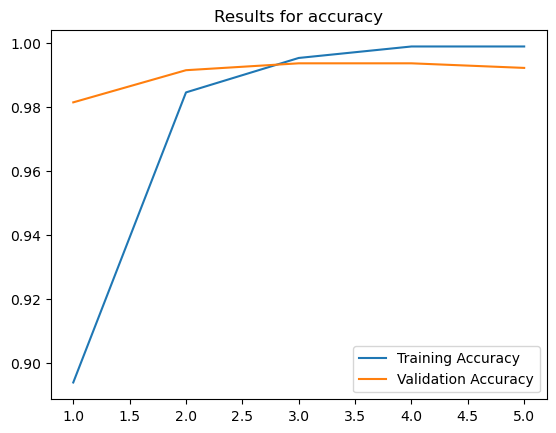

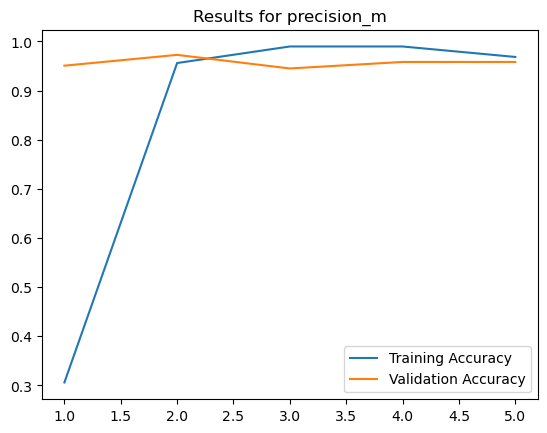

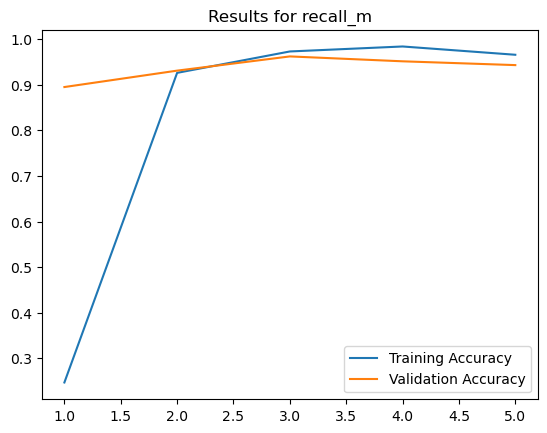

In [221]:
import matplotlib.pyplot as plt
for i in ['accuracy','precision_m', 'recall_m']:
    acc = hist.history[i]
    val_acc = hist.history['val_{}'.format(i)]
    epochs = range (1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, acc, label= 'Training Accuracy') 
    plt.plot(epochs, val_acc, label= 'Validation Accuracy') 
    plt.title('Results for {}'.format(i)) 
    plt.legend() 
    plt.show()

In [222]:
y_pred_probs_rnn = rnn.predict(X_test_seq_padded)

# Convert probabilities to predictions
y_pred_rnn = list()
for i in range(len(y_pred_probs_rnn)):
    if(y_pred_probs_rnn[i] >= 0.5):
        y_pred_rnn.append(1)
    else:
        y_pred_rnn.append(0)


44/44 [==============================] - 0s 6ms/step


In [223]:
precision_rnn, recall_rnn, fscore_rnn, support_rnn = score(y_test_rnn, y_pred_rnn, average = 'binary')
print('Precision: {} / Recall: {} / F1-score: {}'.format(round(precision_rnn, 3),
                                                         round(recall_rnn,3), 
                                                         round(fscore_rnn,3)))

Precision: 0.989 / Recall: 0.951 / F1-score: 0.97
